# Policy plots

In [74]:
from huggingface_hub import hf_hub_download, HfApi
from plotnine import ggplot, aes, geom_point, geom_line
from skopt import load
from stable_baselines3 import PPO

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.utils import evaluate_agent
from rl4fisheries.envs.asm_fns import get_r_devs

import numpy as np
import pandas as pd
import ray

In [2]:
## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}

## Load

In [3]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM1.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM2.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM3.pkl")

esc_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM1.pkl")
esc_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM2.pkl")
esc_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM3.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM1.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM2.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM3.pkl")

In [4]:
cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

esc_UM1 = load(esc_UM1_file)
esc_UM2 = load(esc_UM2_file)
esc_UM3 = load(esc_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [5]:
base_fname = "sb3/rl4fisheries/results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-64-32-16-chkpnt3.zip")
PPO_mw_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM1-64-32-16-chkpnt3.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-chkpnt1.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-64-32-16-chkpnt1.zip")
PPO_mw_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM2-64-32-16-chkpnt4.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-chkpnt3.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-64-32-16-chkpnt5.zip")
PPO_mw_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM3-64-32-16-chkpnt2.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-chkpnt4.zip")

In [6]:
PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_mw_UM1 = PPO.load(PPO_mw_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_mw_UM2 = PPO.load(PPO_mw_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_mw_UM3 = PPO.load(PPO_mw_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

## Policy plot utilities

In [58]:
from itertools import product

def obs_to_mwt(obs, asm_env):
    return asm_env.parameters['min_wt'] + (
        asm_env.parameters['max_wt'] - asm_env.parameters['min_wt']
    ) * (obs + 1) / 2

def obs_to_bms(obs, asm_env):
    return asm_env.bound * (obs + 1) / 2

def get_mwt_policy(mwt_obs_list, *, agent, asm_env):
    mwt_list = [obs_to_mwt(mwt, asm_env) for mwt in mwt_obs_list]
    return {
        'mwt': mwt_list, 
        'fishing_intensity': [ 
            0.5 * (1 + agent.predict(np.float32([mwt]))[0][0]) 
            for mwt in mwt_obs_list
        ],
    }

def get_bms_policy(bms_obs_list, *, agent, asm_env):
    bms_list = [obs_to_bms(bms, asm_env) for bms in bms_obs_list]
    return {
        'bms': bms_list, 
        'fishing_intensity': [ 
            0.5 * (1 + agent.predict(np.float32([bms]))[0][0]) 
            for bms in bms_obs_list
        ],
    }

def get_2obs_policy(bms_obs_list, mwt_obs_list, *, agent, asm_env):
    mwt_list = [obs_to_mwt(mwt, asm_env) for mwt in mwt_obs_list]
    bms_list = [obs_to_bms(bms, asm_env) for bms in bms_obs_list]

    predictors = list(product(bms_list, mwt_list))
    bms_list_long = [pred[0] for pred in predictors]
    mwt_list_long = [pred[1] for pred in predictors]
    
    return {
        'bms': bms_list_long, 
        'mwt': mwt_list_long,
        'fishing_intensity': [ 
            0.5 * (1 + agent.predict(np.float32([bms, mwt]))[0][0]) 
            for (bms, mwt) in product(bms_obs_list, mwt_obs_list)
        ],
    }

def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}

## UM1

In [49]:
bms_obs_list = np.linspace(-1, -1+0.14, 500)
mwt_obs_list_short = [-0.5, 0, 0.3, 0.5, 0.7, 0.9]
mwt_obs_list = np.linspace(-1,1,500)


UM1_2o_pol = pd.DataFrame(get_2obs_policy(
    bms_obs_list, mwt_obs_list_short, 
    agent = PPO_2o_UM1, 
    asm_env = AsmEnv(config=CFG_UM1_2o),
)) 

UM1_mw_pol = pd.DataFrame(get_mwt_policy(
    mwt_obs_list, 
    agent = PPO_mw_UM1, 
    asm_env = AsmEnv(config=CFG_UM1_mw),
)) 

UM1_bm_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = PPO_bm_UM1, 
    asm_env = AsmEnv(config=CFG_UM1_bm),
)) 

In [66]:
UM1_cr_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list,
        agent = CautionaryRule(
            env = AsmEnv(config=CFG_UM1_bm),
            **(from_radius_theta(*cr_UM1.x)), 
        ),
        asm_env = AsmEnv(config=CFG_UM1_bm),
    )
)

UM1_esc_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list, 
        agent = ConstEsc(
            env = AsmEnv(config=CFG_UM1_bm), escapement=esc_UM1.x[0]
        ),
        asm_env = AsmEnv(config=CFG_UM1_bm),
    )
) 

UM1_msy_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = Msy(
        env = AsmEnv(config=CFG_UM1_bm), mortality=msy_UM1.x[0]
    ), 
    asm_env = AsmEnv(config=CFG_UM1_bm),
)) 

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


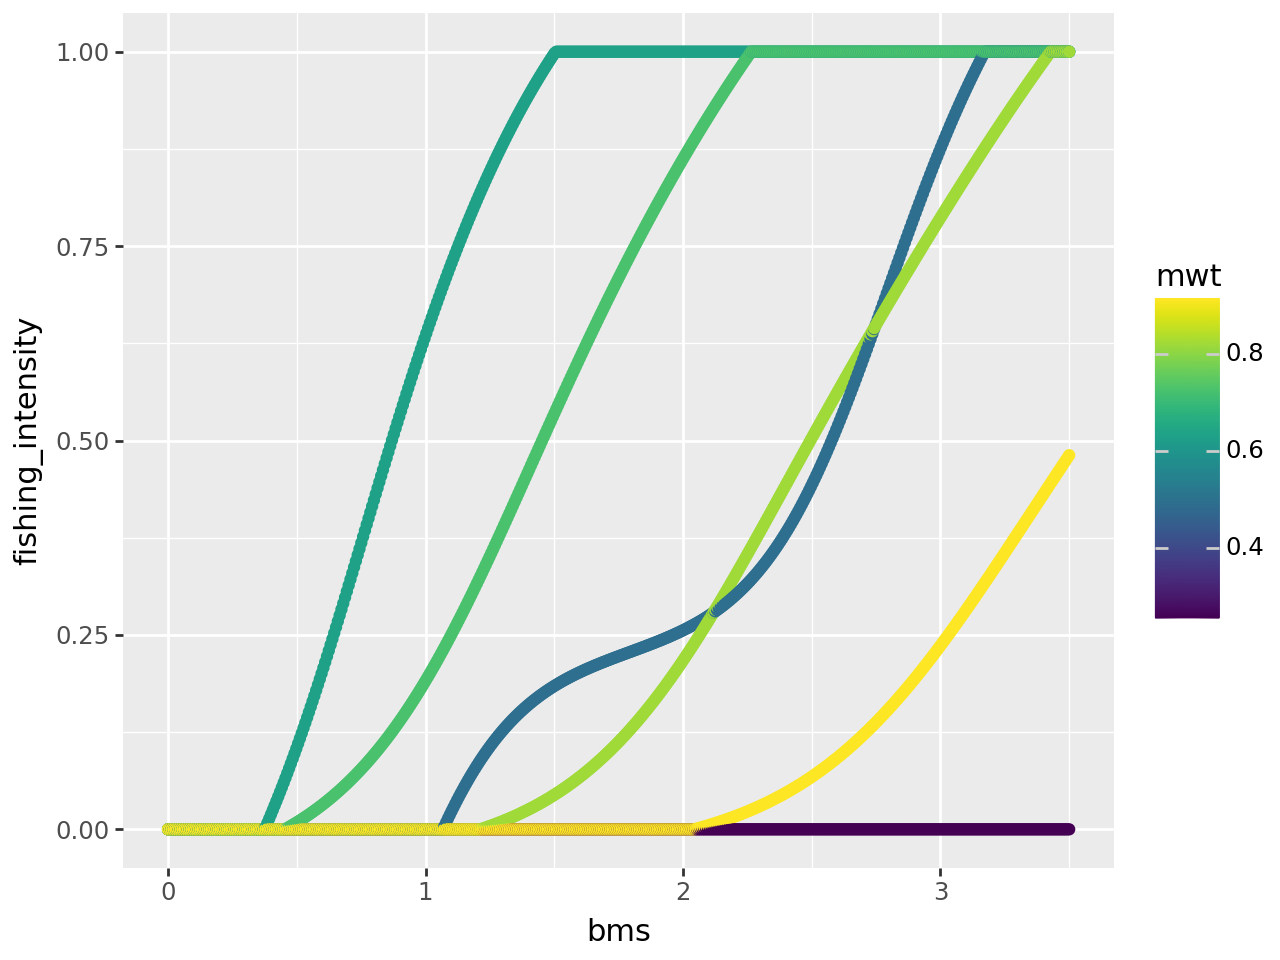

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


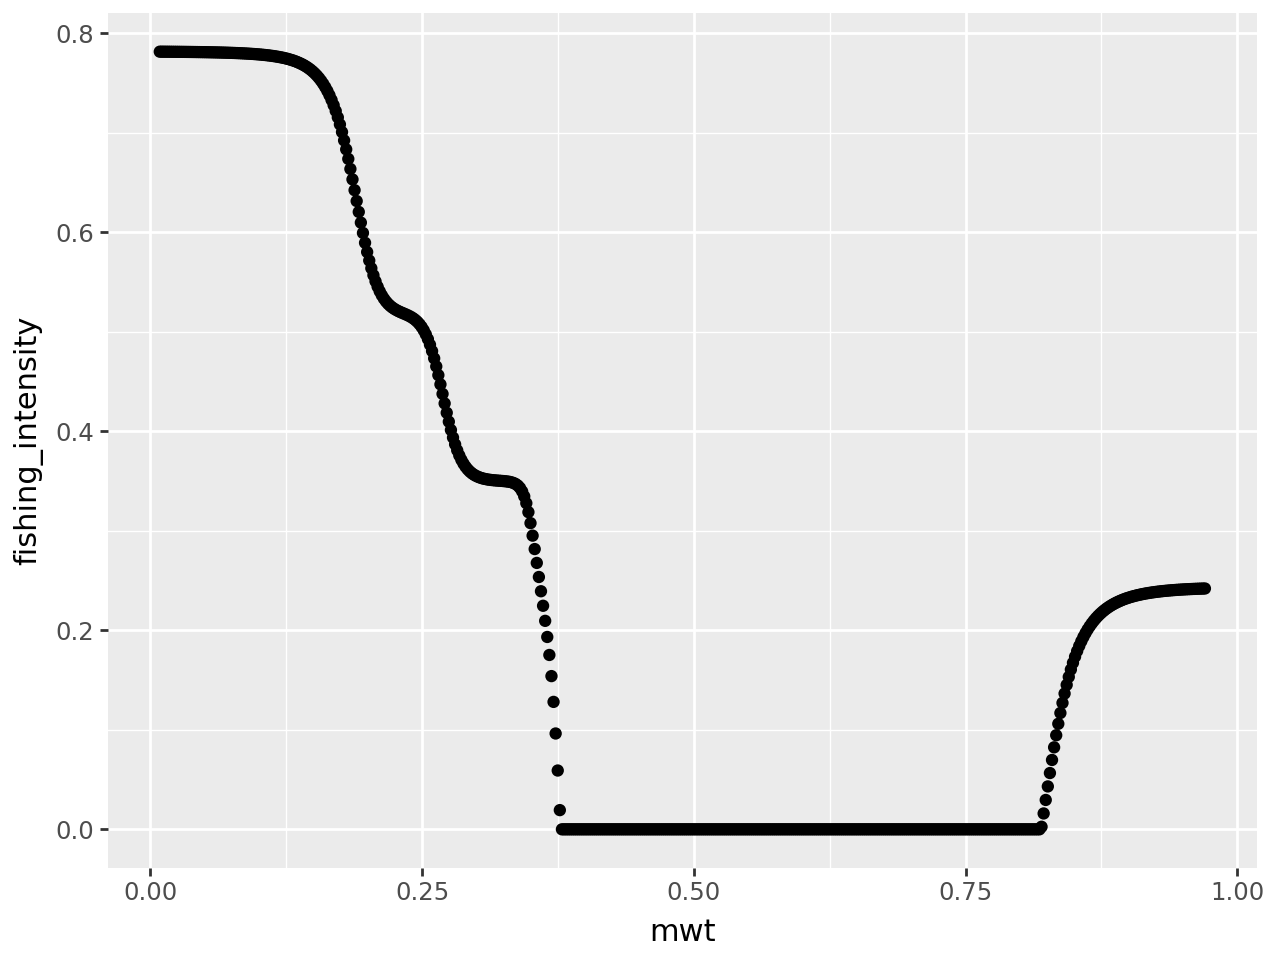

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


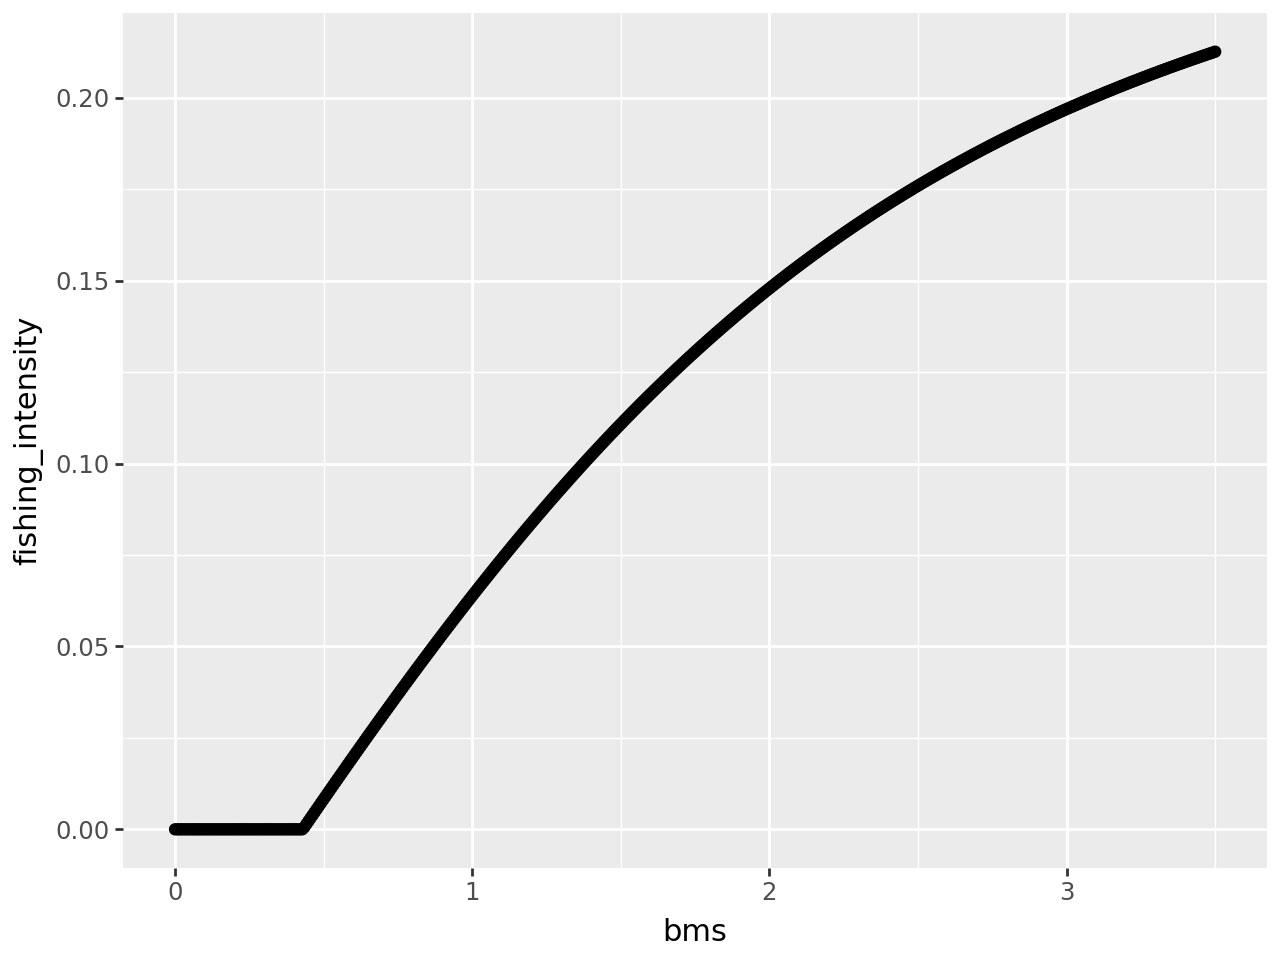

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [67]:
(
    ggplot(UM1_2o_pol, aes(x='bms', y='fishing_intensity', color='mwt')) + geom_point(),
    ggplot(UM1_mw_pol, aes(x='mwt', y='fishing_intensity')) + geom_point(),
    ggplot(UM1_bm_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


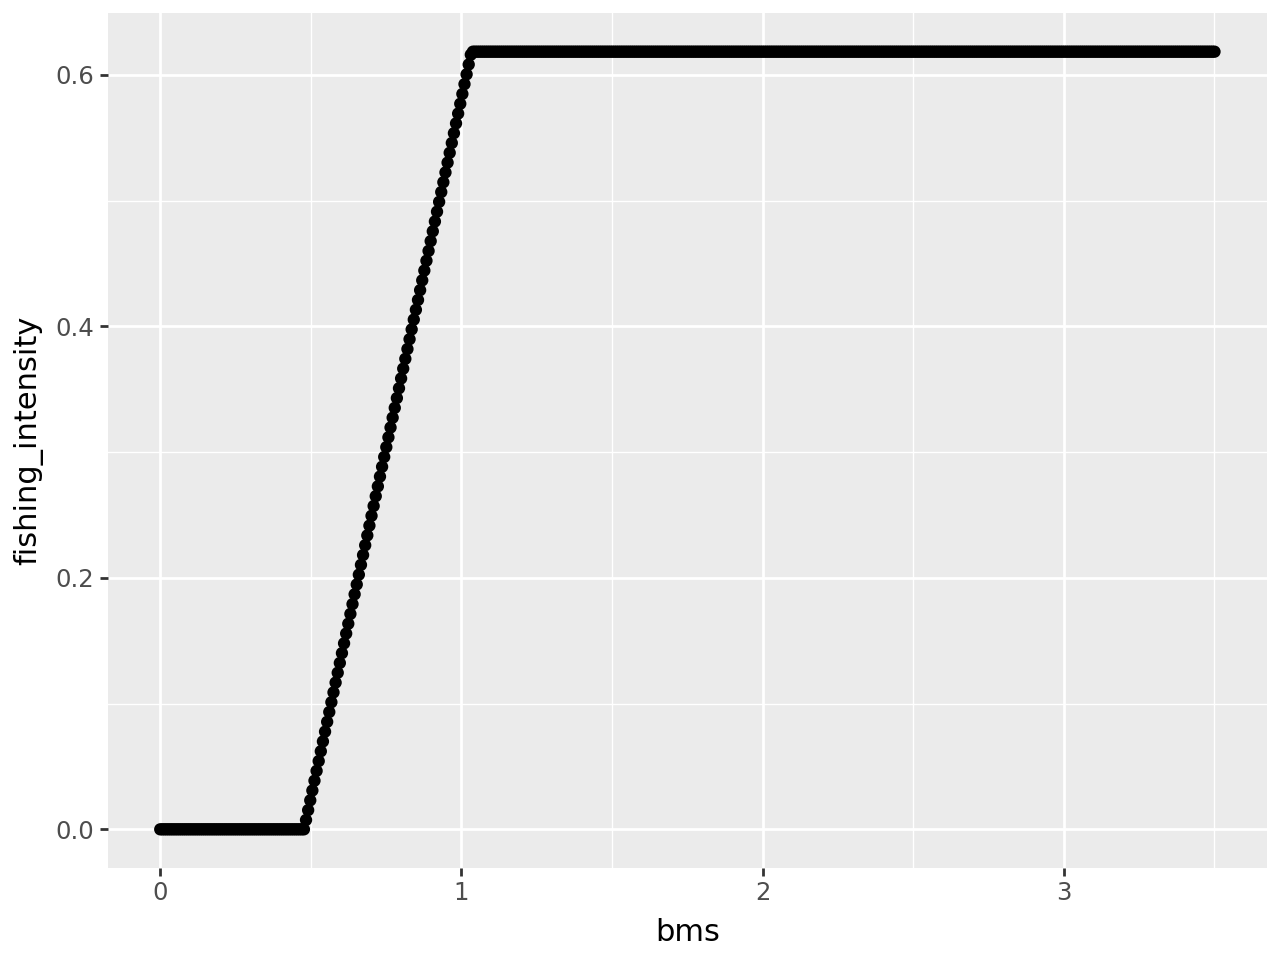

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


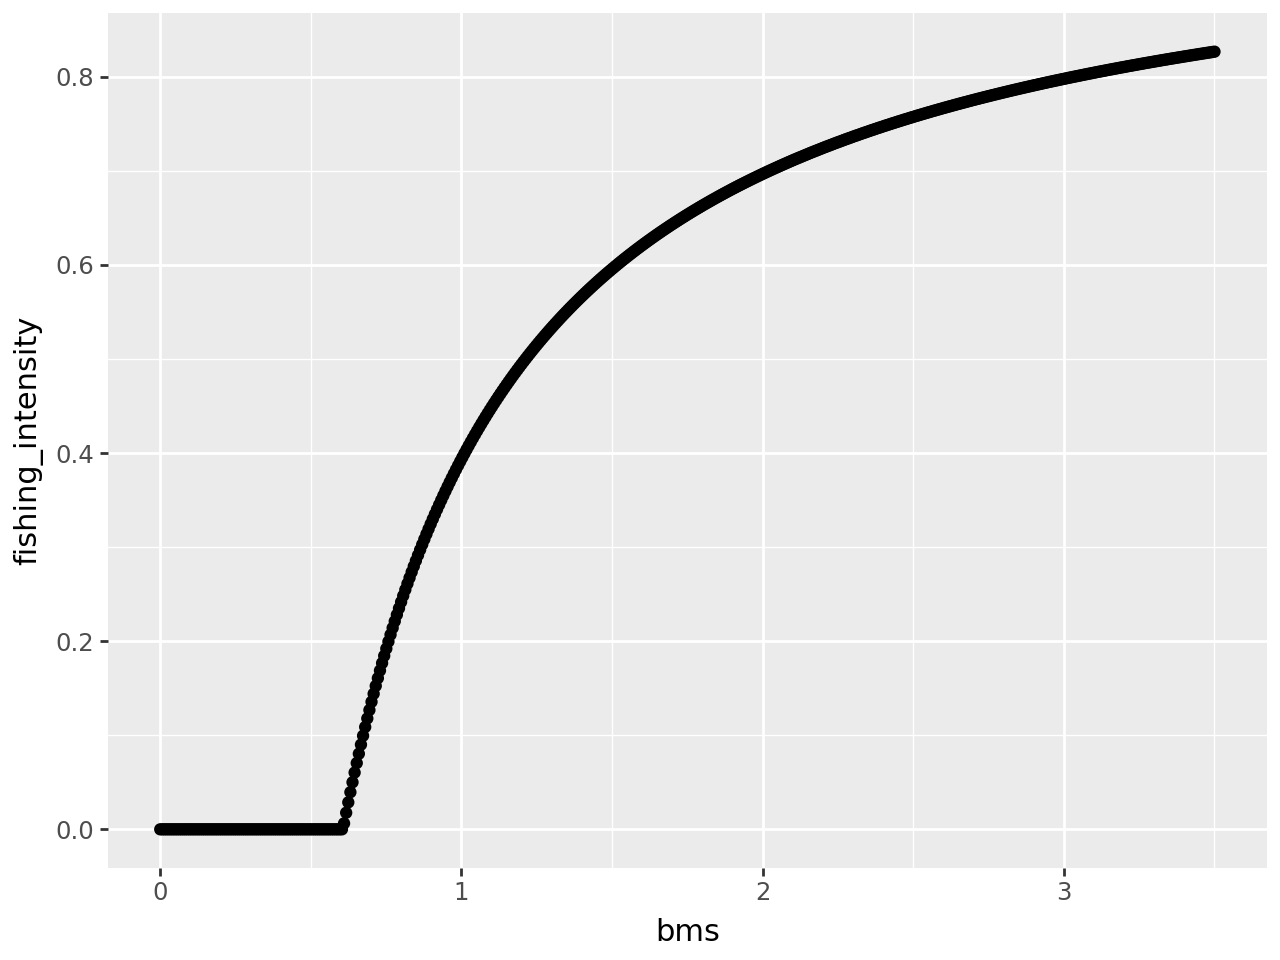

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


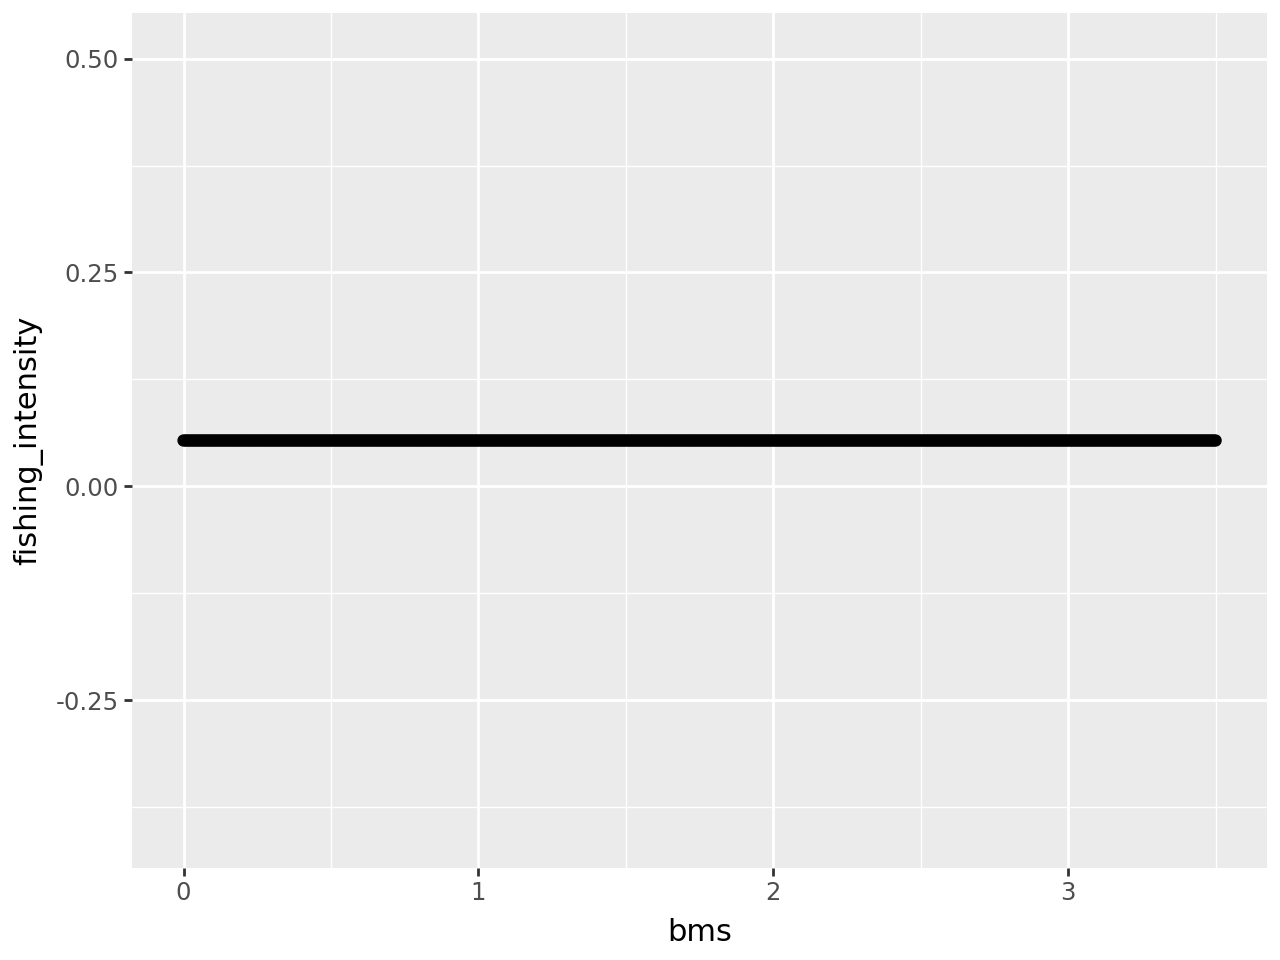

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [68]:
(
    ggplot(UM1_cr_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM1_esc_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM1_msy_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)

## UM2

In [52]:
bms_obs_list = np.linspace(-1, -1+0.14, 500)
mwt_obs_list_short = [-0.5, 0, 0.3, 0.5, 0.7, 0.9]
mwt_obs_list = np.linspace(-1,1,500)


UM2_2o_pol = pd.DataFrame(get_2obs_policy(
    bms_obs_list, mwt_obs_list_short, 
    agent = PPO_2o_UM2, 
    asm_env = AsmEnv(config=CFG_UM2_2o),
)) 

UM2_mw_pol = pd.DataFrame(get_mwt_policy(
    mwt_obs_list, 
    agent = PPO_mw_UM2, 
    asm_env = AsmEnv(config=CFG_UM2_mw),
)) 

UM2_bm_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = PPO_bm_UM2, 
    asm_env = AsmEnv(config=CFG_UM2_bm),
)) 

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


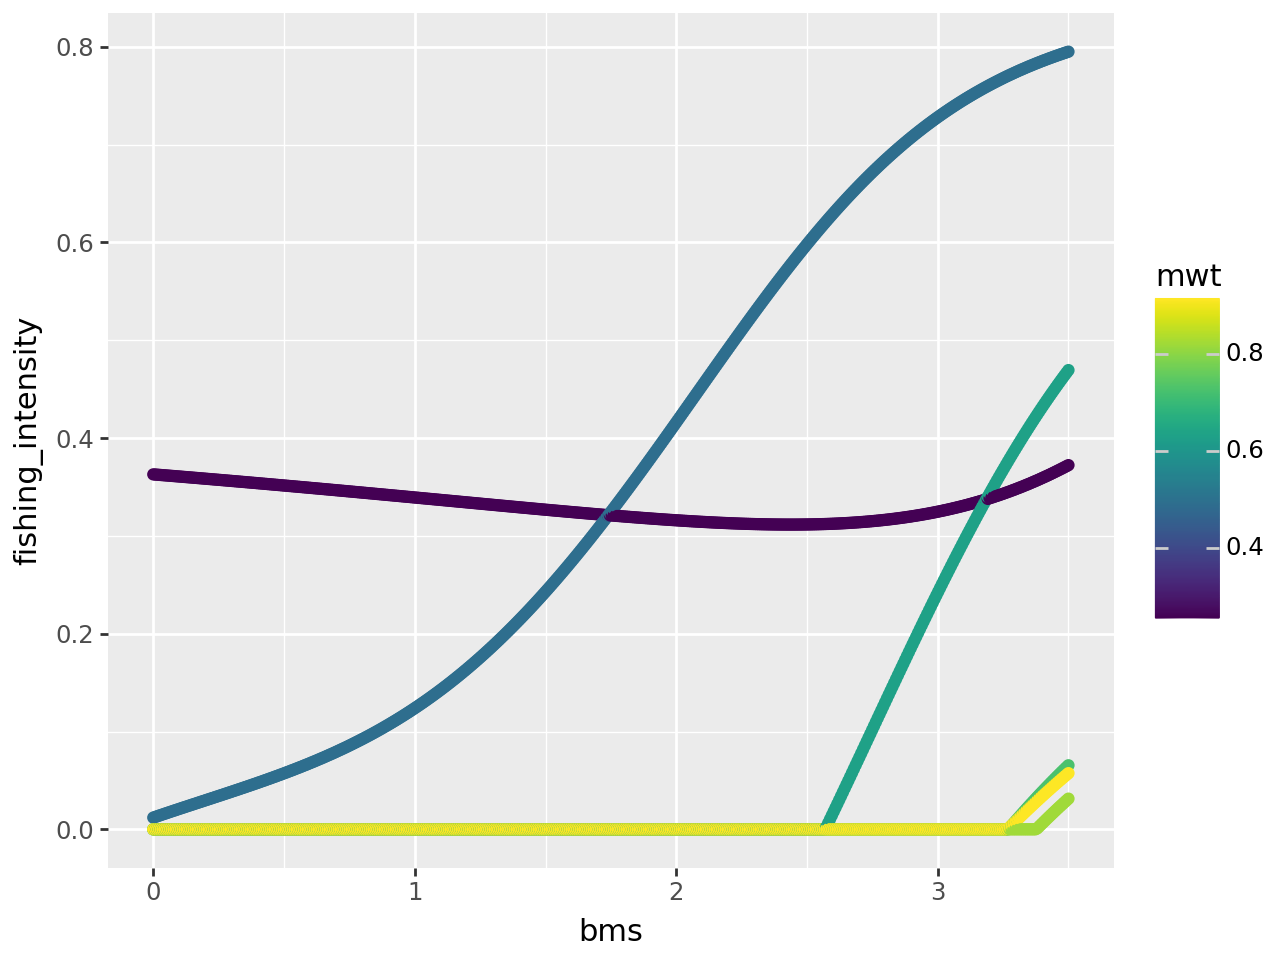

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


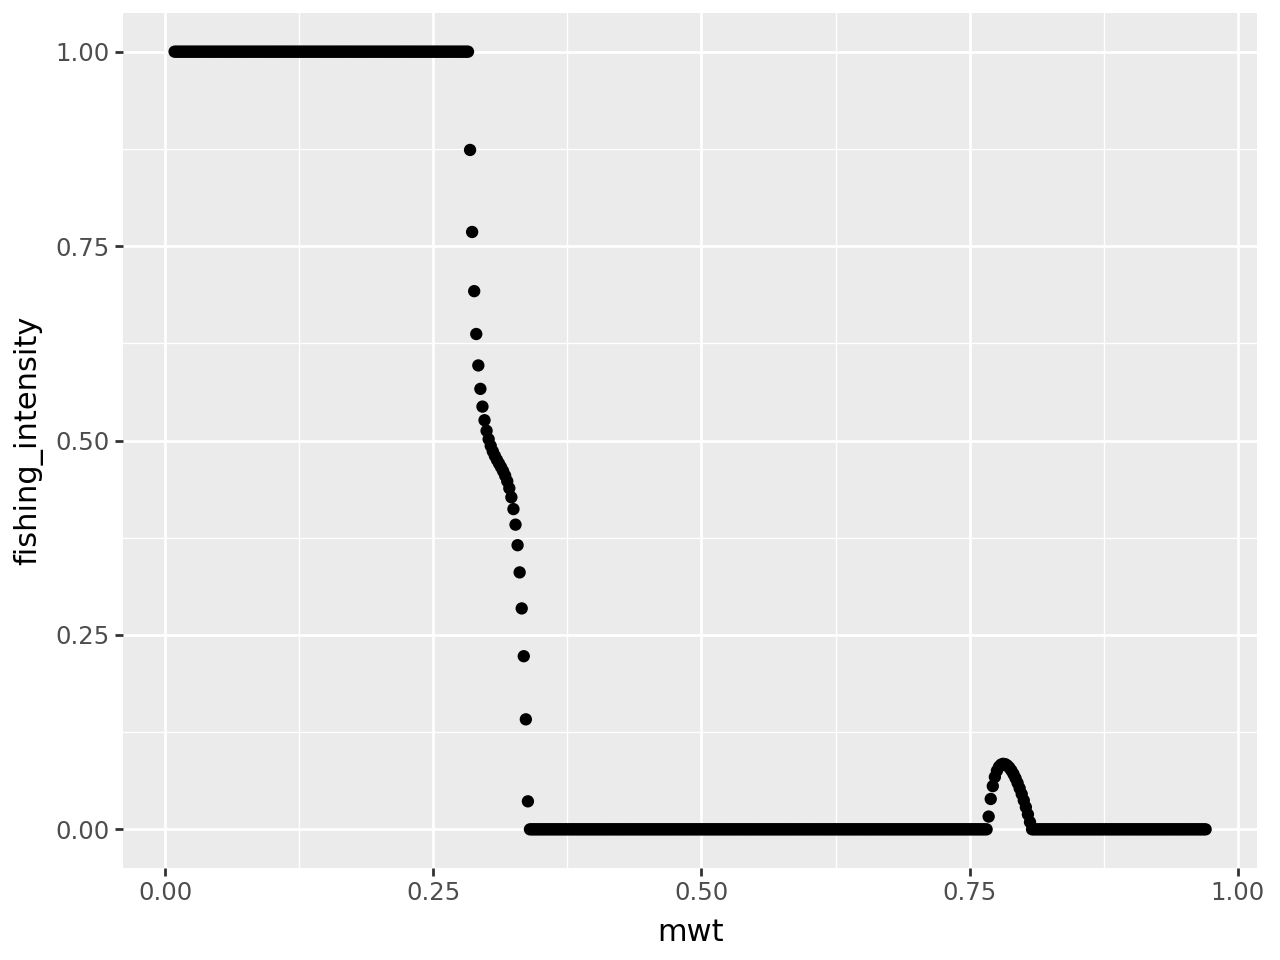

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


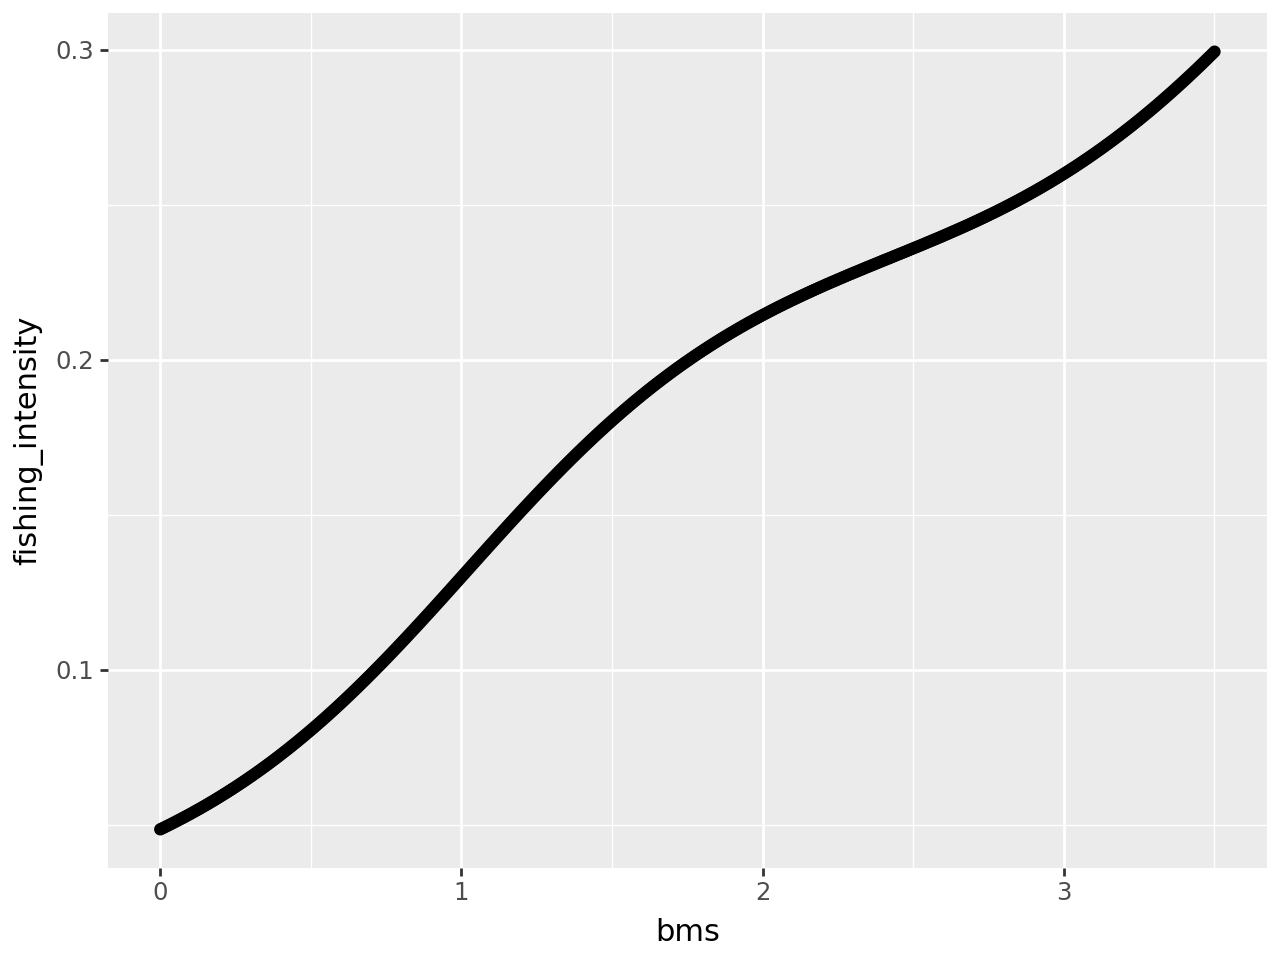

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [53]:
(
    ggplot(UM2_2o_pol, aes(x='bms', y='fishing_intensity', color='mwt')) + geom_point(),
    ggplot(UM2_mw_pol, aes(x='mwt', y='fishing_intensity')) + geom_point(),
    ggplot(UM2_bm_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)

In [69]:
UM2_cr_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list,
        agent = CautionaryRule(
            env = AsmEnv(config=CFG_UM2_bm),
            **(from_radius_theta(*cr_UM2.x)), 
        ),
        asm_env = AsmEnv(config=CFG_UM2_bm),
    )
)

UM2_esc_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list, 
        agent = ConstEsc(
            env = AsmEnv(config=CFG_UM2_bm), escapement=esc_UM2.x[0]
        ),
        asm_env = AsmEnv(config=CFG_UM2_bm),
    )
) 

UM2_msy_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = Msy(
        env = AsmEnv(config=CFG_UM2_bm), mortality=msy_UM2.x[0]
    ), 
    asm_env = AsmEnv(config=CFG_UM2_bm),
)) 

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


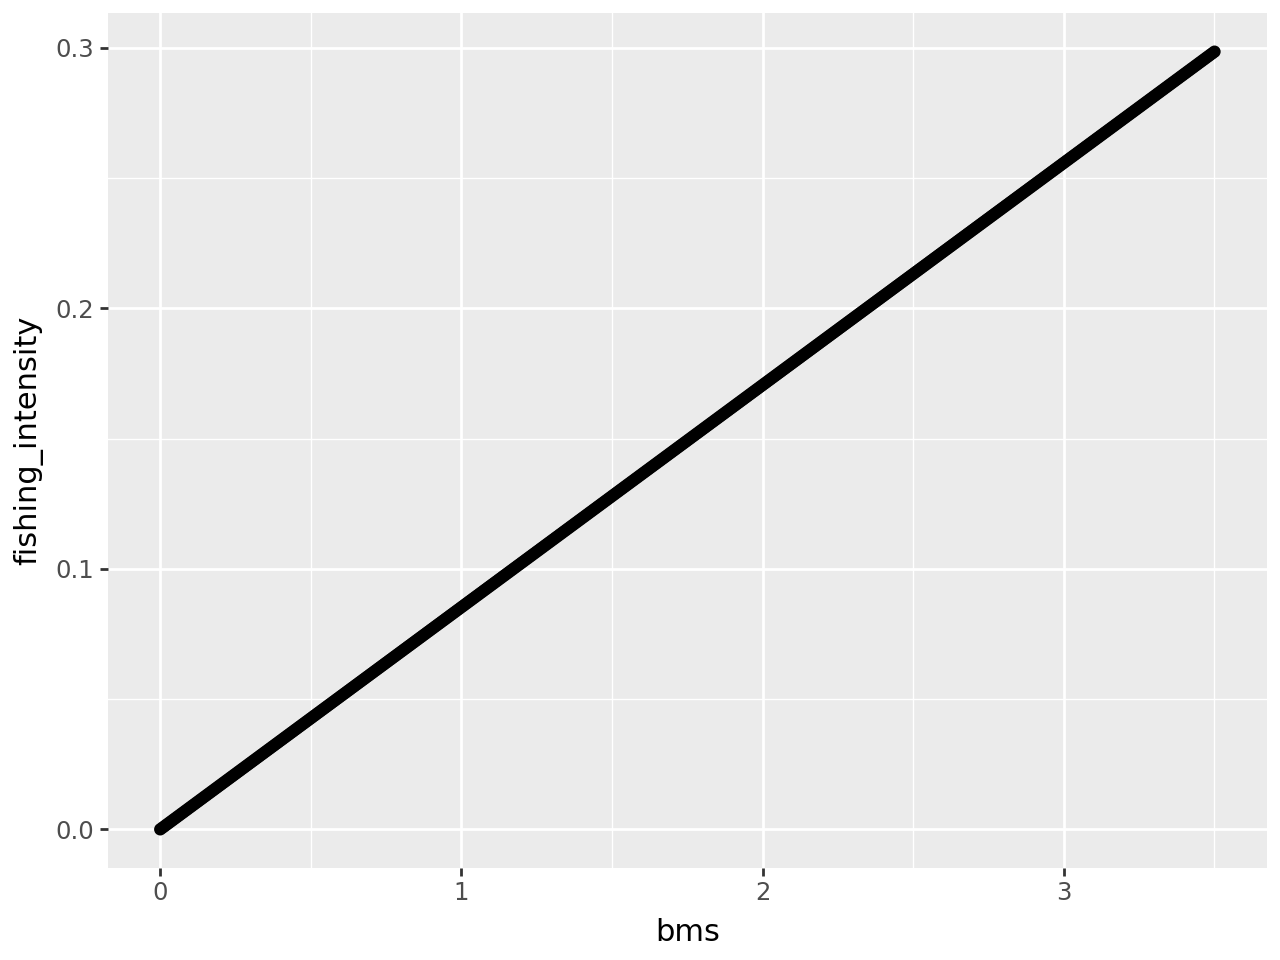

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


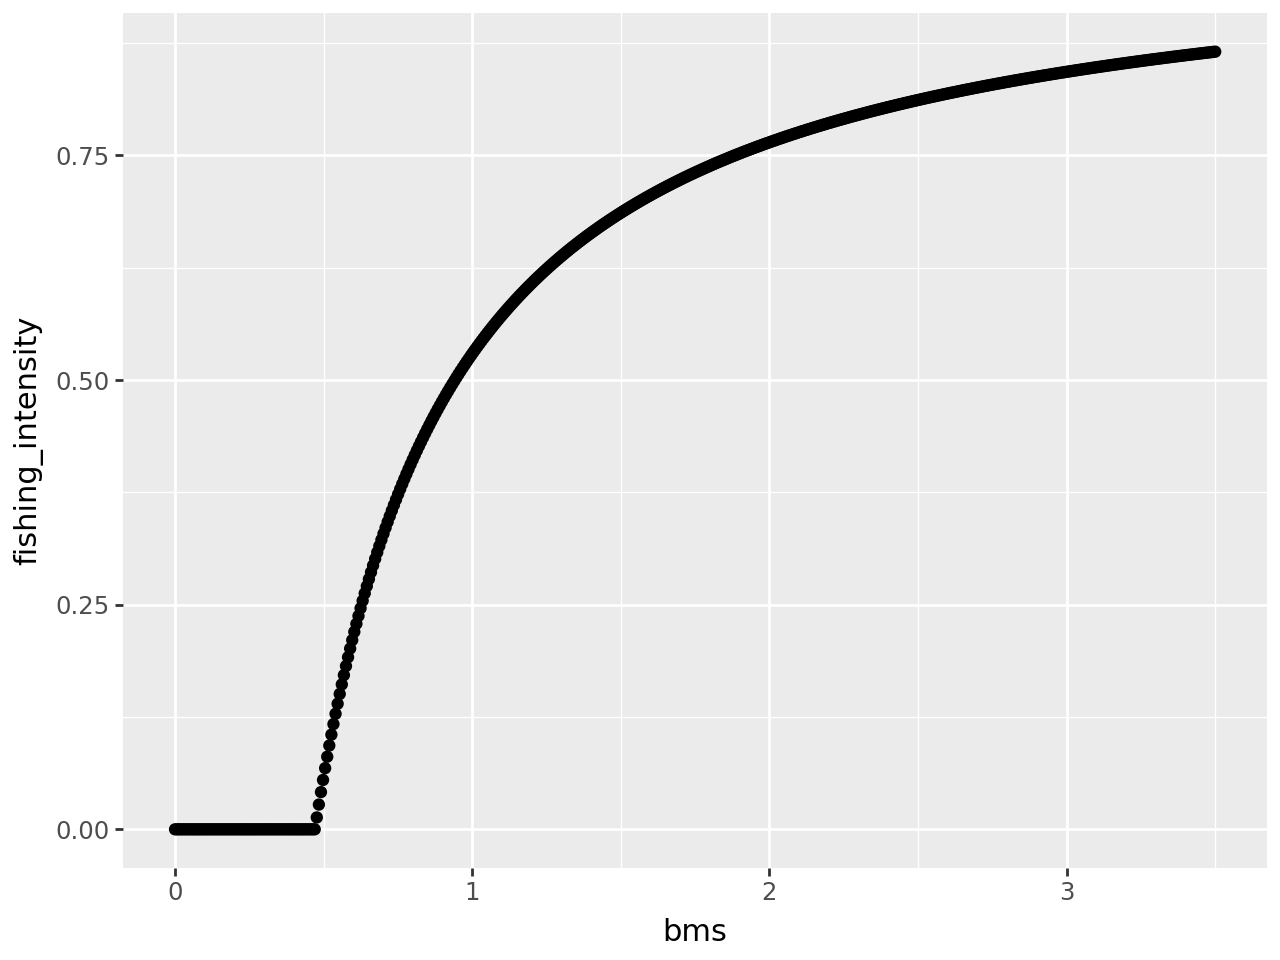

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


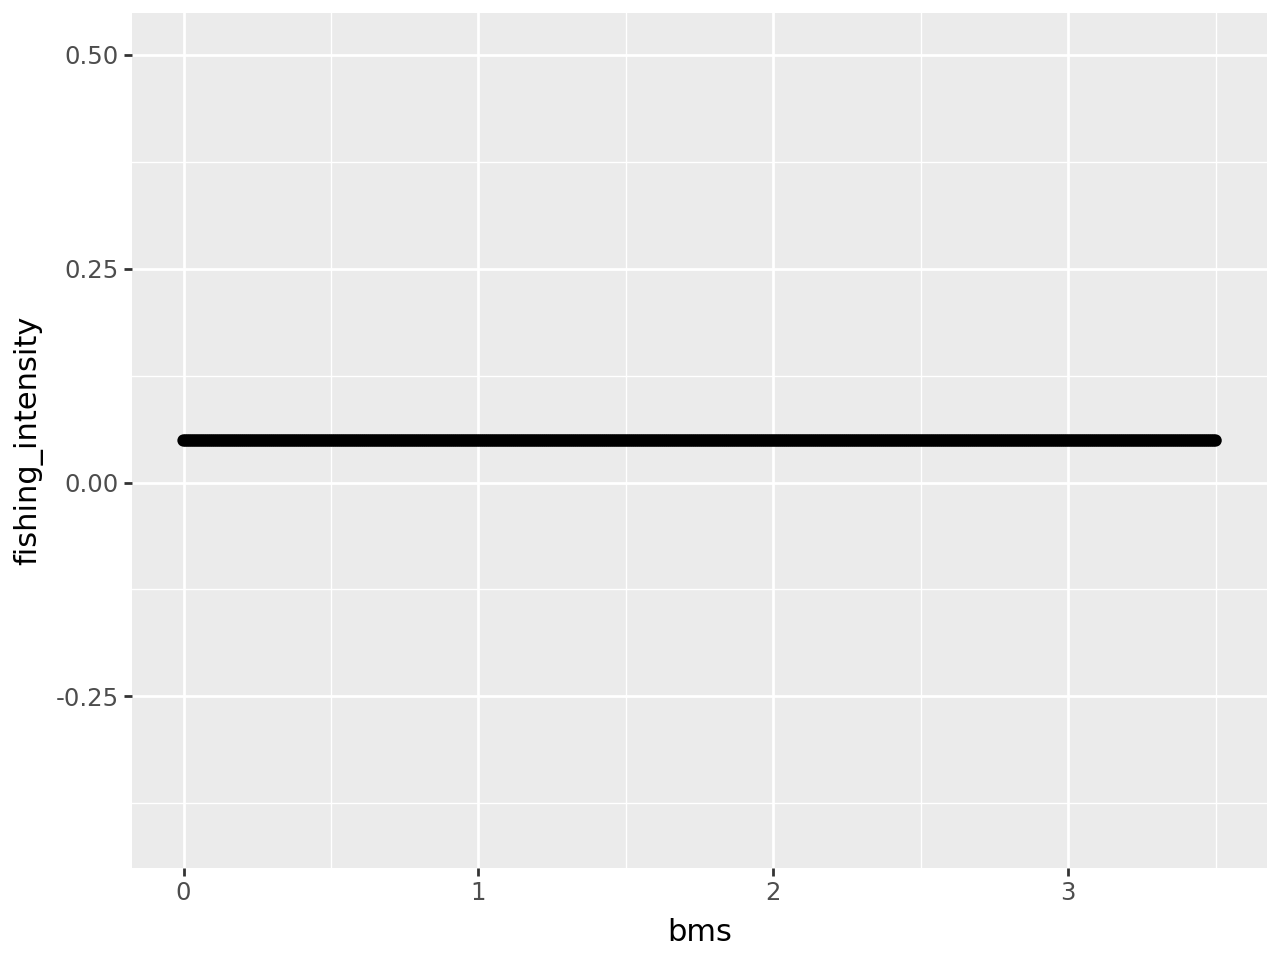

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [71]:
(
    ggplot(UM2_cr_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM2_esc_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM2_msy_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)

## UM3

In [54]:
bms_obs_list = np.linspace(-1, -1+0.14, 500)
mwt_obs_list_short = [-0.5, 0, 0.3, 0.5, 0.7, 0.9]
mwt_obs_list = np.linspace(-1,1,500)


UM3_2o_pol = pd.DataFrame(get_2obs_policy(
    bms_obs_list, mwt_obs_list_short, 
    agent = PPO_2o_UM3, 
    asm_env = AsmEnv(config=CFG_UM3_2o),
)) 

UM3_mw_pol = pd.DataFrame(get_mwt_policy(
    mwt_obs_list, 
    agent = PPO_mw_UM3, 
    asm_env = AsmEnv(config=CFG_UM3_mw),
)) 

UM3_bm_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = PPO_bm_UM3, 
    asm_env = AsmEnv(config=CFG_UM3_bm),
)) 

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


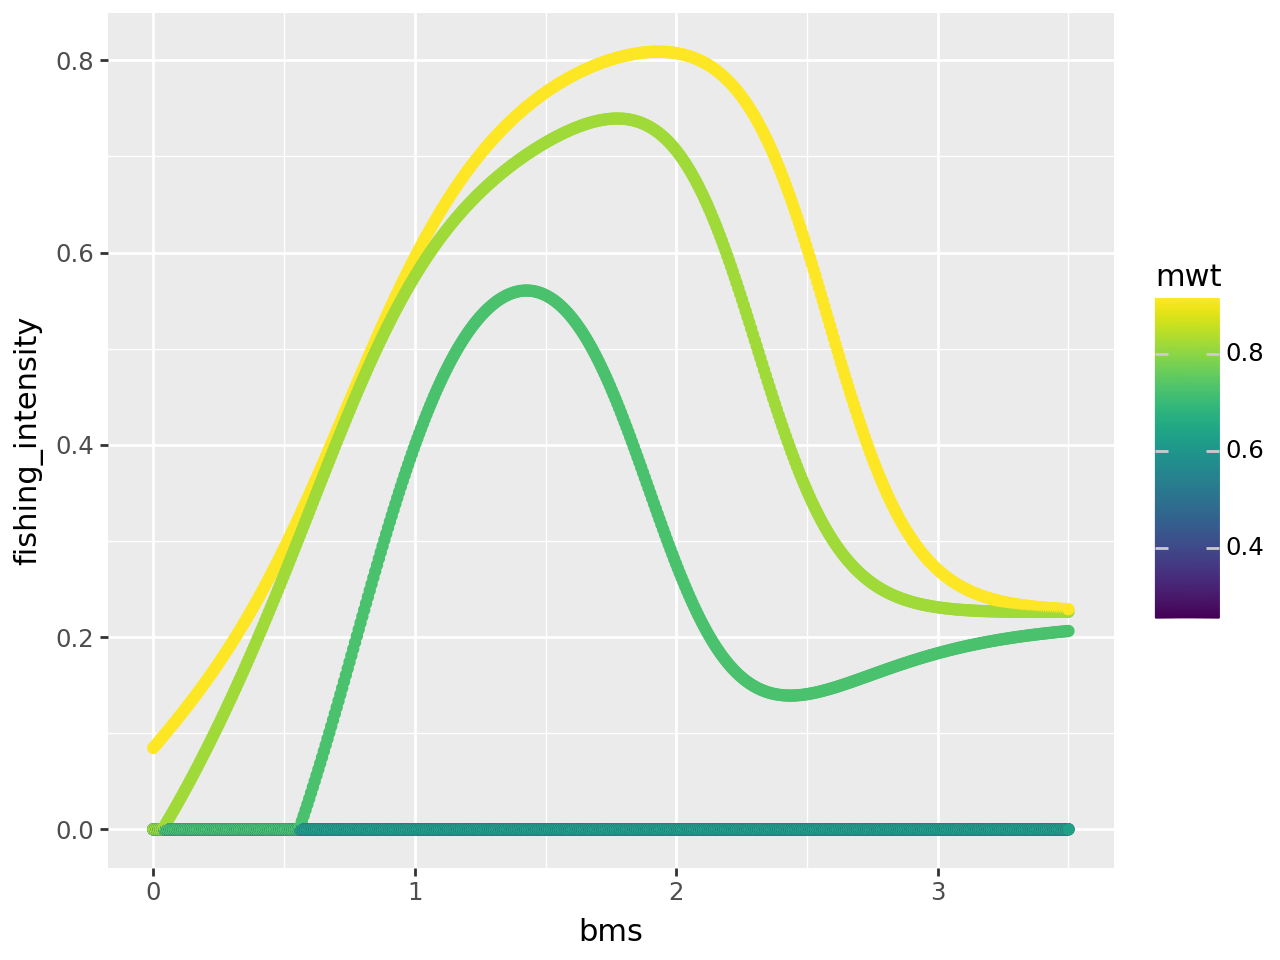

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


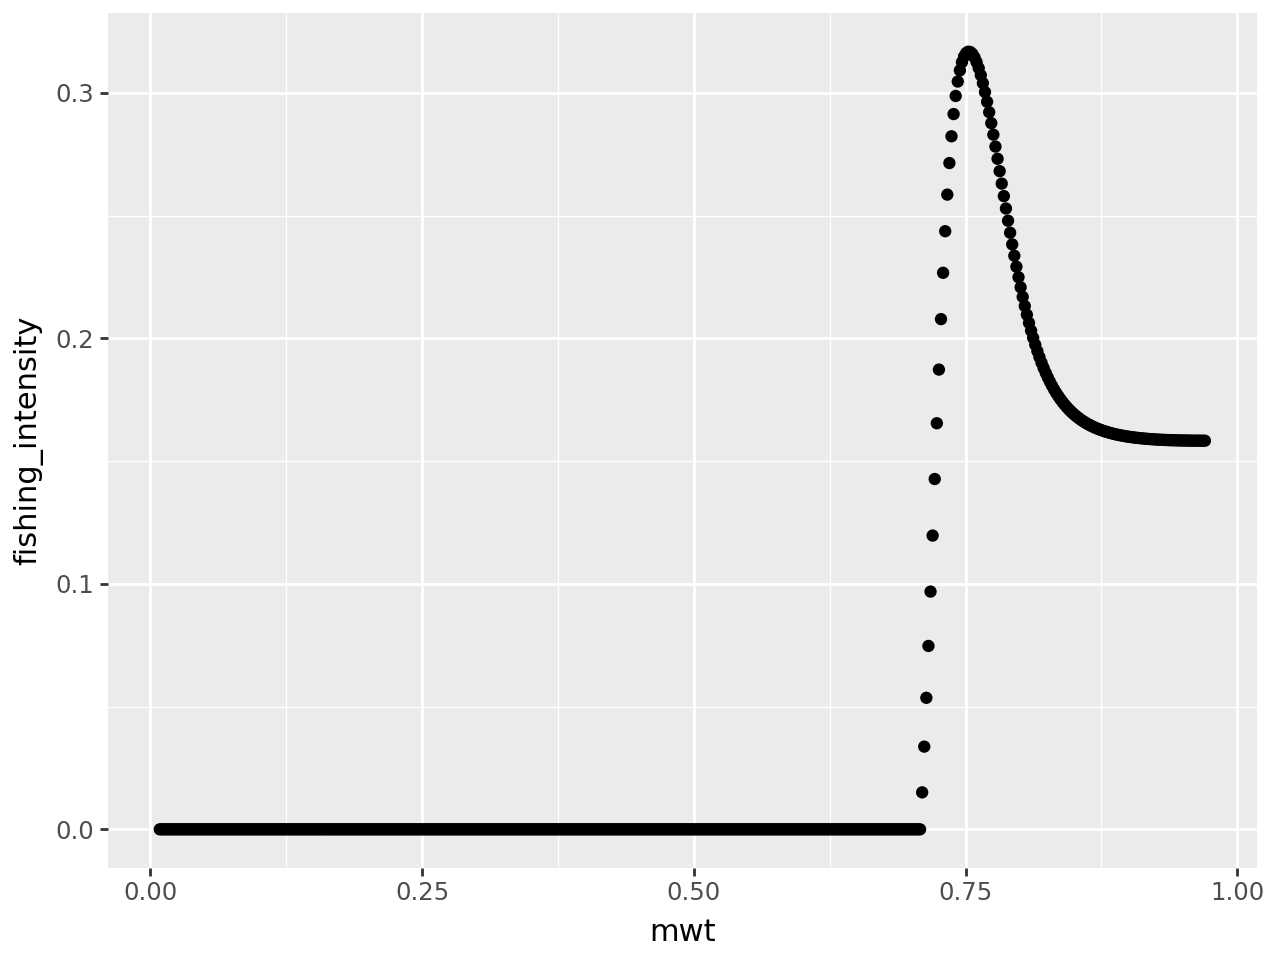

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


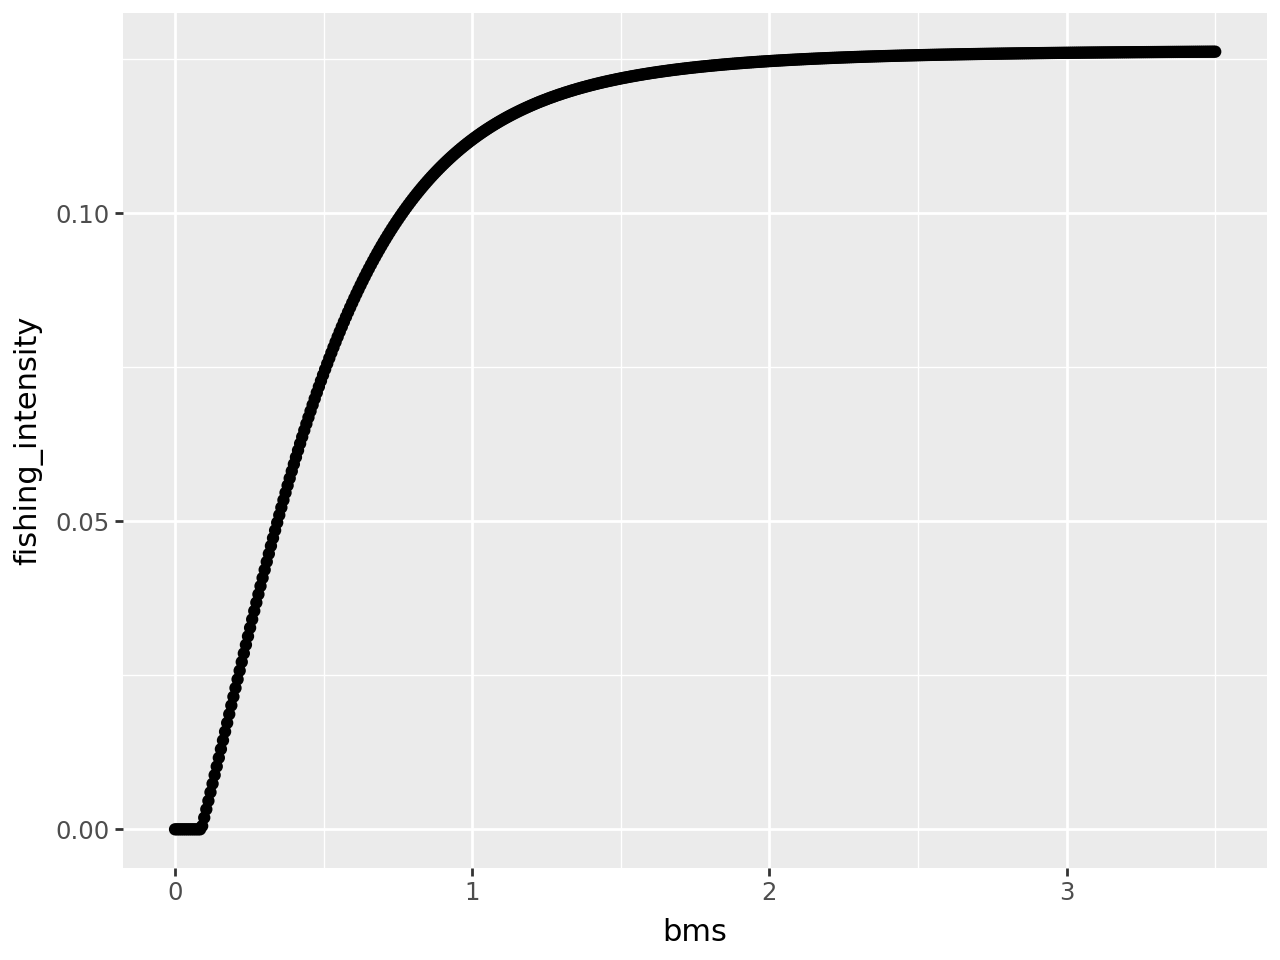

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [55]:
(
    ggplot(UM3_2o_pol, aes(x='bms', y='fishing_intensity', color='mwt')) + geom_point(),
    ggplot(UM3_mw_pol, aes(x='mwt', y='fishing_intensity')) + geom_point(),
    ggplot(UM3_bm_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)

In [72]:
UM3_cr_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list,
        agent = CautionaryRule(
            env = AsmEnv(config=CFG_UM3_bm),
            **(from_radius_theta(*cr_UM3.x)), 
        ),
        asm_env = AsmEnv(config=CFG_UM3_bm),
    )
)

UM3_esc_pol = pd.DataFrame(
    get_bms_policy(
        bms_obs_list, 
        agent = ConstEsc(
            env = AsmEnv(config=CFG_UM3_bm), escapement=esc_UM3.x[0]
        ),
        asm_env = AsmEnv(config=CFG_UM3_bm),
    )
) 

UM3_msy_pol = pd.DataFrame(get_bms_policy(
    bms_obs_list, 
    agent = Msy(
        env = AsmEnv(config=CFG_UM3_bm), mortality=msy_UM3.x[0]
    ), 
    asm_env = AsmEnv(config=CFG_UM3_bm),
)) 

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


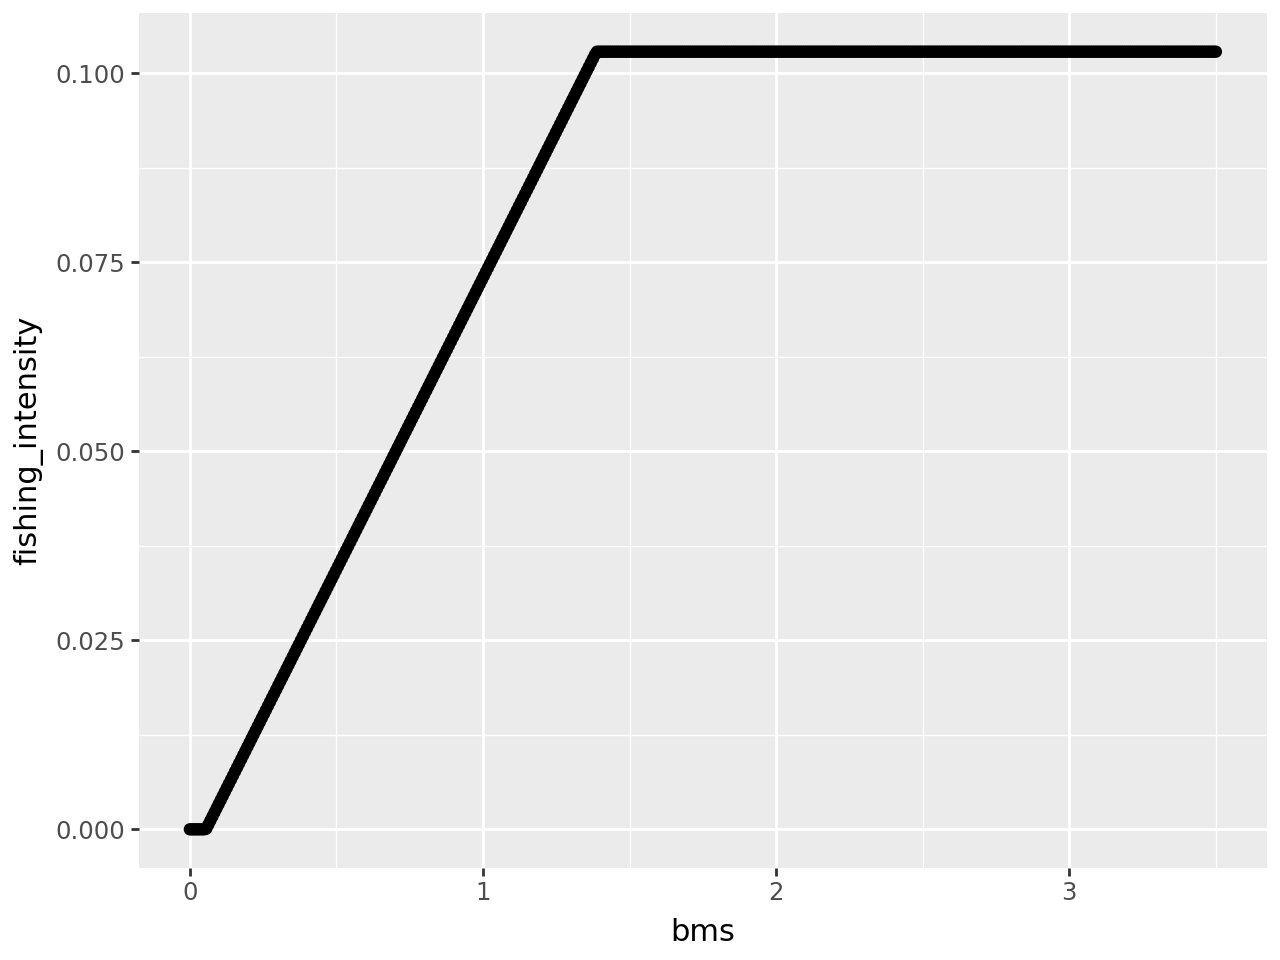

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


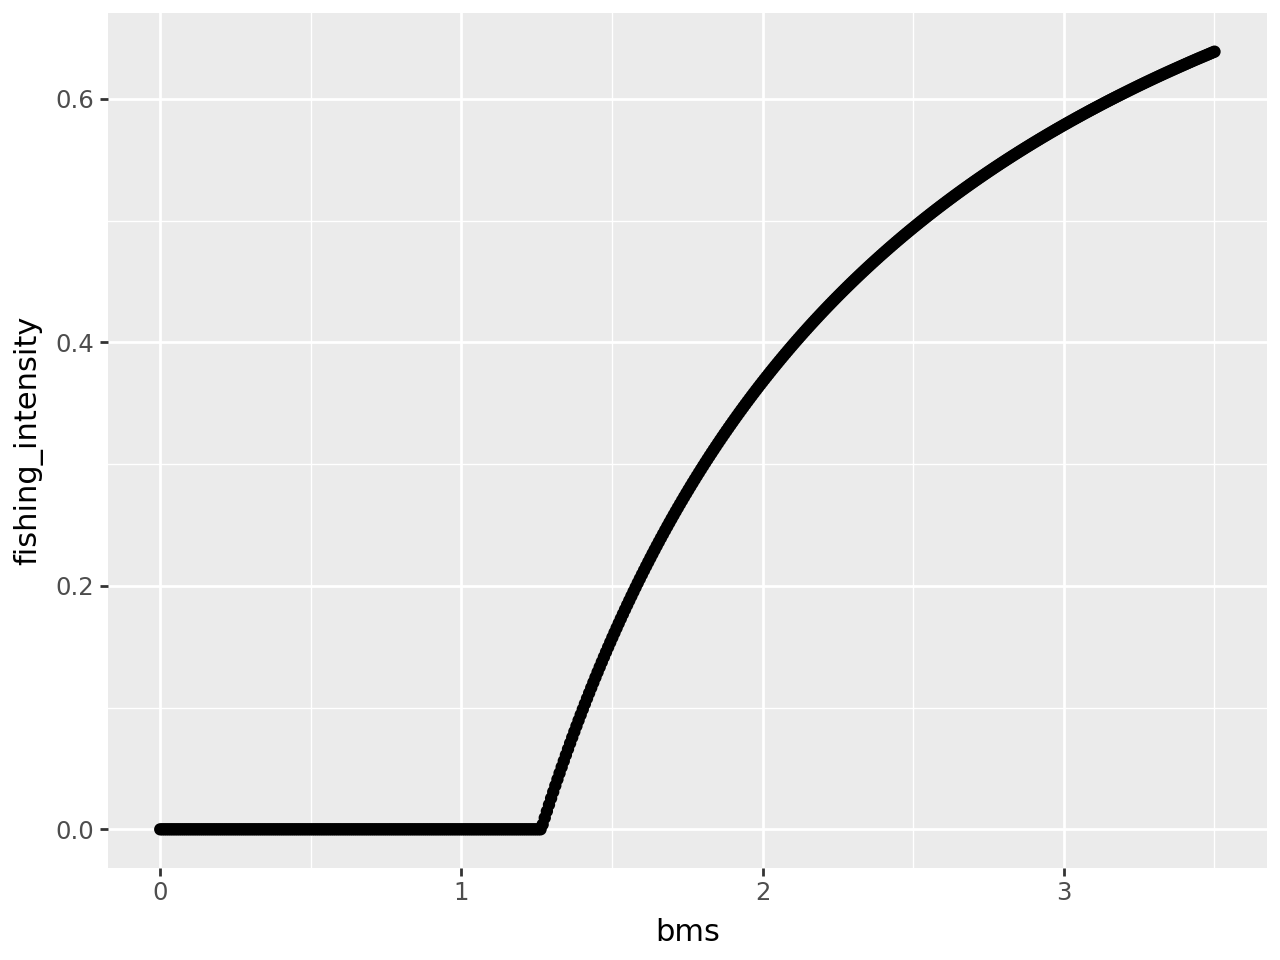

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


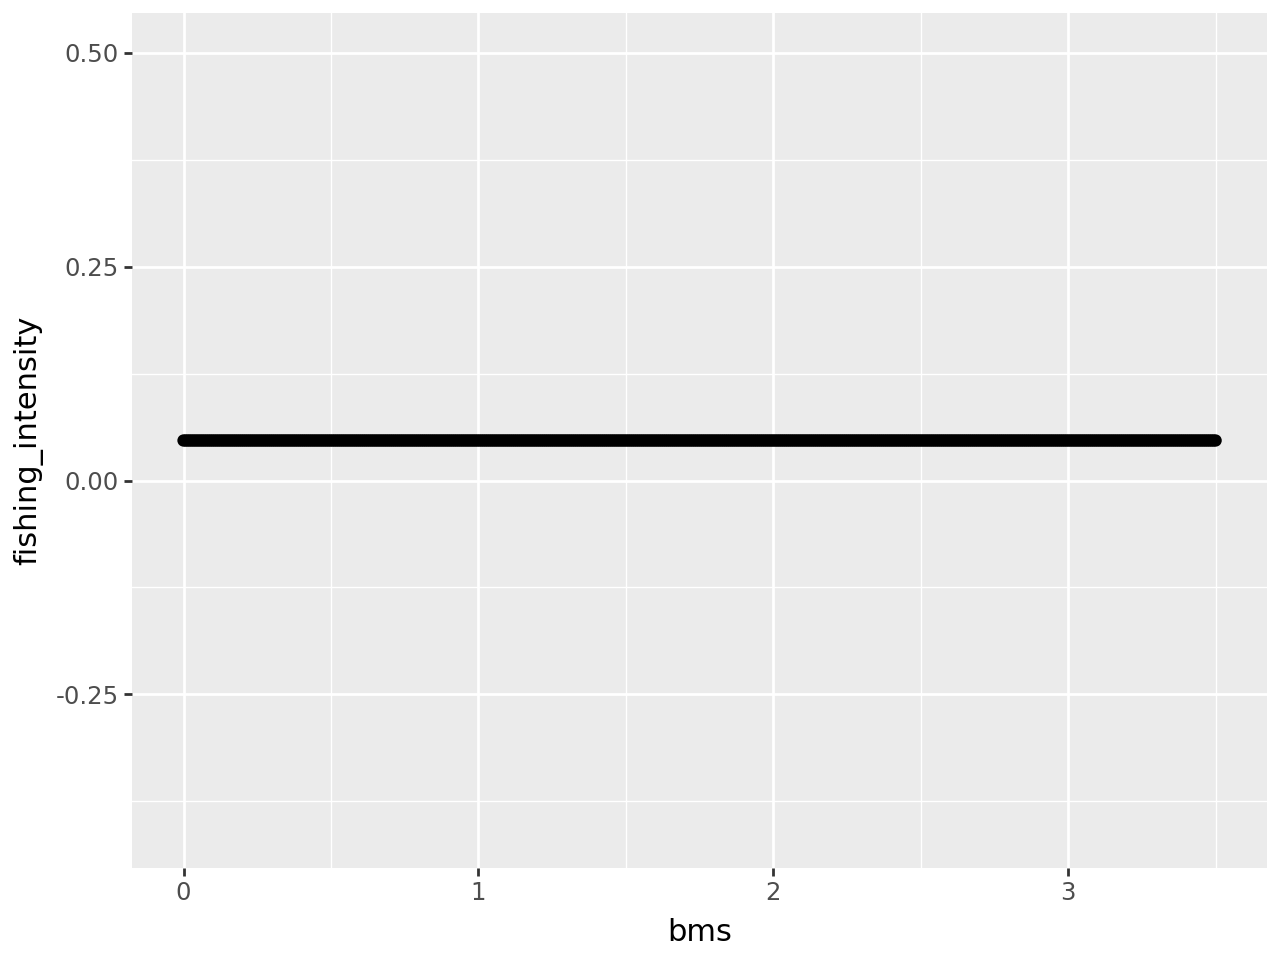

(<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>)

In [73]:
(
    ggplot(UM3_cr_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM3_esc_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
    ggplot(UM3_msy_pol, aes(x='bms', y='fishing_intensity')) + geom_point(),
)